QLBM algorithm solving Burgers equation using D1Q2 scheme (Section III and IV-A)

In [1]:
import numpy as np
from qiskit import QuantumCircuit, transpile, assemble, Aer, IBMQ, QuantumRegister, AncillaRegister, execute
from qiskit.circuit.library import Permutation
from qiskit.quantum_info.operators import Operator
from qiskit.quantum_info import Statevector, StabilizerState, Clifford
from qiskit.visualization import array_to_latex, plot_histogram, plot_bloch_multivector
from qiskit.result import marginal_counts
import time, math
from math import pi, sqrt
from qiskit.providers.aer import AerSimulator
import pickle
from sklearn.metrics import mean_squared_error
from collections import Counter
import scipy.io as spio
import qiskit.result
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
from pdf2image import convert_from_path
from qiskit import BasicAer

import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib

plt.rc('axes', labelsize=9.)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=9.)    # fontsize of the tick labels
plt.rc('ytick', labelsize=9.)    # fontsize of the tick labels
plt.rc('legend', fontsize=9.)    # fontsize of the tick labels
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)


/Users/fatimaezahrachrit/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: The qiskit.ignis package is deprecated and has been supersceded by the qiskit-experiments project. Refer to the migration guide: https://github.com/Qiskit/qiskit-ignis#migration-guide on how to migrate to the new project.
  import sys


Constants definition 

In [2]:
# D1Q2 lattice constants
rho_a = 0.4  # coefficients of initial condition
rho_b = 1
w = np.array([0.5, 0.5]) # weight coefficients
cx = np.array([1, -1])   #lattice velocities
csq = 1   #square of sound speed
ux = 0.  # advection x-velocity

Functions

In [3]:
def compute_feq(rho, w, cx, ux, csq):
    feq = np.zeros((2,M))
    for i in range(2):
        feq[i] = w[i] * (1 + cx[i]*ux/csq) * rho
    return feq

def ini(x, w, cx, ux, csq):
    M = len(x)
    rho = np.zeros(M)    
    rho =  rho_a * np.cos(2*math.pi*x/L) + rho_b  #initial density
    feq = compute_feq(rho, w, cx, ux, csq)
    f = feq
    return f, rho

def update_encoding(qc, f, M):
    for k in range(M):
        for i in range(2):    
            amp0 = np.sqrt(1-f[i][k])
            amp1 = np.sqrt(f[i][k])
            qc.initialize([amp0, amp1], i+2*k)  
    return qc

def collision_Burgers(circ, k):
    circ.cx(0+2*k, 1+2*k)
    circ.ch(1+2*k, 0+2*k)
    circ.cx(1+2*k, 0+2*k)
    circ.cx(0+2*k, 1+2*k)
    circ.cz(0+2*k, 1+2*k)
    circ.draw()
    return circ

def computeStreamingPattern(n):
    if (n >= 4):  #minimum for streaming is 2 sites, corresonding to 4qubits
        #first pair of qubits
        streamingPattern = [n-2, 3]
        for i in range(2,n-3):
            if i%2 == 0:  
                streamingPattern.extend([i-2, i+3])
        #last pair of qubits
        streamingPattern.extend([n-4,1])
    else:
        streamingPattern = []
    return streamingPattern

def classical_streaming(M, qubit_counts, numberOfShots):
    #read post collision probabilities
    f = np.zeros((2,M))
    fout = np.zeros((2,M))
    for k in range(M):
        for i in range(2):
            if '1' in qubit_counts[i+2*k]:
                fout[i][k] = qubit_counts[i+2*k]['1'] / numberOfShots
    
    # classical streaming
    for k in range(1,M):    #right 
        f[0][k] = fout[0][k-1]

    for k in range(M-1):     #left
        f[1][k] = fout[1][k+1]

    #periodic BC
    f[0][0] = f[0][M-1]
    f[1][M-1] = f[1][0]

    return f

One time step of QLBM with classical streaming (Section III)

In [4]:
def oneTimeStep_classicalStreaming(f, M, numberOfShots, backend):
    qc = QuantumCircuit(2*M)
    #step1: encoding
    qc = update_encoding(qc, f, M)
    qc.barrier()
    
    #step2: collision
    for k in range(M):
        qc = collision_Burgers(qc, k)
        
    #step3: measurement
    qc.measure_all()
    result = execute(qc, backend, shots=numberOfShots).result()
    counts = result.get_counts(0)
    qubit_counts = [marginal_counts(counts, [qubit]) for qubit in range(2*M)]
    
    #step4: streaming
    f = classical_streaming(M, qubit_counts, numberOfShots)
    return f, qc

One time step of QLBM with quantum streaming (Section IV-A)

In [5]:
def oneTimeStep_quantumStreaming(f, M, numberOfShots, backend):
    qc = QuantumCircuit(2*M)
    #step1: encoding
    qc = update_encoding(qc, f, M)
    qc.barrier()
    
    #step2: collision
    for k in range(M):
        qc = collision_Burgers(qc, k)
        
    #step3: streaming    
    qc.append(Permutation(num_qubits = n, pattern = computeStreamingPattern(n)), range(n))
    
    #step4: measurement
    qc.measure_all()
    result = execute(qc, backend, shots=numberOfShots).result()
    counts = result.get_counts(0)
    qubit_counts = [marginal_counts(counts, [qubit]) for qubit in range(2*M)]

    #read post streaming probabilities
    fout = np.zeros((2,M))
    for k in range(M):
        for i in range(2):
            if '1' in qubit_counts[i+2*k]:
                fout[i][k] = qubit_counts[i+2*k]['1'] / numberOfShots
    f = fout
    #periodic BC
    f[0][0] = f[0][M-1]
    f[1][M-1] = f[1][0]

    return f, qc

Classical implementation of QLBM algorithm

In [6]:
# number operators
n1 = np.array([[0, 0, 0, 0],
              [0, 1, 0, 0],
              [0, 0, 0, 0],
              [0, 0, 0, 1]])
n2 = np.array([[0, 0, 0, 0],
              [0, 0, 0, 0],
              [0, 0, 1, 0],
              [0, 0, 0, 1]])
 
# collision operator  
C_Burgers = np.array([[1, 0, 0, 0],
                      [0, 1/np.sqrt(2), 1/np.sqrt(2), 0],
                      [0, -1/np.sqrt(2), 1/np.sqrt(2), 0],
                      [0, 0, 0, -1]])


def classicalOneTimeStep(f, M):
#     initial combined state
    initial_state = np.zeros((M, 4))
    for i in range(M):
        amp00 = np.sqrt( (1-f[0][i]) * (1-f[1][i]) )#2nd index = lattice site
        amp10 = np.sqrt( (1-f[0][i]) * f[1][i] )
        amp01 = np.sqrt( (1-f[1][i]) * f[0][i] )
        amp11 = np.sqrt( f[0][i] * f[1][i] )
#         print(amp00)
        initial_state[i][0] = amp00
        initial_state[i][1] = amp01
        initial_state[i][2] = amp10
        initial_state[i][3] = amp11
    

#     post-collision state (4xlattice_sites)
    post_collision_state = C_Burgers.dot(initial_state.conjugate().transpose())
    
   # post-collision distribution
    post_collision_distribution = np.zeros((2, M))
    for i in range(M):
        post_collision_distribution[0][i] = post_collision_state.conjugate().transpose()[i].dot(n1.dot( post_collision_state.transpose()[i]))
        post_collision_distribution[1][i] = post_collision_state.conjugate().transpose()[i].dot(n2.dot( post_collision_state.transpose()[i]))

#     STREAMING STEP 
    f[0][1:M] = post_collision_distribution[0][0:M-1]
    f[1][0:M-1] = post_collision_distribution[1][1:M]

#      periodic BC
    f[0][0] = f[0][M-1]
    f[1][M-1] = f[1][0]

    return f

Simulation parameters 

In [7]:
L = 8  # domain length 
M = L+1  # number of lattice sites (from 0 to L)
n = 2*M   # number of qubits
x = np.array(range(M)) # 1D lattice

#initial condition: gaussian distribution
sigma0 = L/10  # mean
mu0 = int(np.ceil(L/2)) # variance

numberOfShots = 100000  # number of shots
maxT = 2   # number of time steps

# choose simulation backend
backend = 'aer_simulator_matrix_product_state' 
# backend =  'aer_simulator_statevector' 


Main loop 

In [8]:
# initialization
fini, rho = ini(x, w, cx, ux, csq)  
fq_classical = fini
fq_quantum = fini
fClassical = fini

for t in range(1, maxT+1):
    print('t = ', t)
    # quantum implementation, classical streaming
    fq_classical, qc = oneTimeStep_classicalStreaming(fq_classical, M, numberOfShots, Aer.get_backend(backend)) 
    rhoq_classical = fq_classical[0] + fq_classical[1]
    # quantum implementation, quantum streaming
    fq_quantum, qc = oneTimeStep_quantumStreaming(fq_quantum, M, numberOfShots, Aer.get_backend(backend))
    rhoq_quantum = fq_quantum[0] + fq_quantum[1]
    # classical implementation
    fClassical = classicalOneTimeStep(fClassical, M)
    rhoClassical = fClassical[0] + fClassical[1]
print('Done')

t =  1


/Users/fatimaezahrachrit/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: The QuantumCircuit.__iadd__() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  if sys.path[0] == '':


t =  2
Done


Results output and plot

RMSE of quantum solution with classical streaming:
 0.002367694984974191
RMSE of quantum solution with quantum streaming:
 0.0025878466303882997


Text(0, 0.5, 'Density')

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


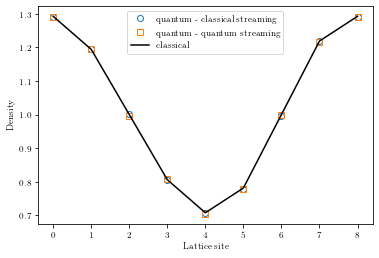

In [9]:
MSE = mean_squared_error(rhoClassical, rhoq_classical)
RMSE = math.sqrt(MSE)
print("RMSE of quantum solution with classical streaming:\n", RMSE)

MSE = mean_squared_error(rhoClassical, rhoq_quantum)
RMSE = math.sqrt(MSE)
print("RMSE of quantum solution with quantum streaming:\n", RMSE)

plt.plot(x, rhoq_classical,'o', markersize = 6, markerfacecolor='none')
plt.plot(x, rhoq_quantum,'s', markersize = 6, markerfacecolor='none')
plt.plot(x, rhoClassical, 'k')
plt.legend(['quantum - classical streaming', 'quantum - quantum streaming', 'classical']) 
plt.xlabel('Lattice site')
plt.ylabel('Density')